# Loading trained pipelines
This notebook can be used to recreate the results of the report

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score, roc_auc_score, f1_score, matthews_corrcoef, precision_score, recall_score
from utils import (
    ConvNet,
    test_loop,
    plot_predictions,
    load_data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Select a pipeline

There are 3 different pipelines: `One-hot+CNN`, `DNABERT+Dense`, `DNABERT+CNN` which were applied to human promoters (classification) and yeast promoters (regression).


To switch between `One-hot` and `DNABERT` embeddings, change `embedding` to either 'onehot' or 'dnabert'

If using a `DNABERT` embedding, to choose either a CNN or a dense layer change `add_cnn` accordingly.

Variables that can be changed have a 'Change me' comment next to them.

Running the cell below will load the specified model and `DataLoader`


In [4]:
promoter = 'yeast' # Change me
embedding = 'onehot' # Change me

n_outputs = 1 if promoter == 'yeast' else 2

if embedding == 'onehot':
    val_loader = load_data(promoter, embedding)
    
    in_c = 4
    hidden_size = int(np.ceil(next(iter(val_loader))[0].shape[1]*(0.5**6)))

    model = ConvNet(n_outputs, in_c, hidden_size)
    model.to(device)

    model = torch.load('example/trained_models/one-hot_'+promoter+'.pth',map_location=torch.device(device))
if embedding == 'dnabert':
    val_loader, config, dnabert_base = load_data(promoter, embedding)
    
    add_cnn = False # Change me
    
    if add_cnn:
        from dnabertcnn import DNABERTConvNet
        model = DNABERTConvNet(dnabert_base, config, n_outputs)
        model.to(device)    
        model = torch.load('example/trained_models/dnabert-cnn_'+promoter+'.pth',map_location=torch.device(device))
    else:
        from dnabertdense import DNABERTConvNet
        model = DNABERTConvNet(dnabert_base, config, n_outputs)
        model.to(device)    
        model = torch.load('example/trained_models/dnabert-dense_'+promoter+'.pth',map_location=torch.device(device))

Loaded yeast promoters dataset 
 261667 Training examples 
 32708 Validation and test examples 

one-hot encoding sequences: 100%|█████████████████████████████████████████████████████████| 32708/32708 [00:02<00:00, 14159.48it/s]


# Prediction on validation set
With the model and dataloader ready, running the cell below will pass the data through the model and generate evaluation metrics. If the promoter selected was yeast (regression) a prediction plot will be created.

Using onehot pipeline on yeast promoters.
1023it [01:17, 13.17it/s]                                                                                                          

Yeast Promoters Validation set: 
 Avg loss: 0.002946, R2 score: 0.470 
 32708 Promoters evaluated. 



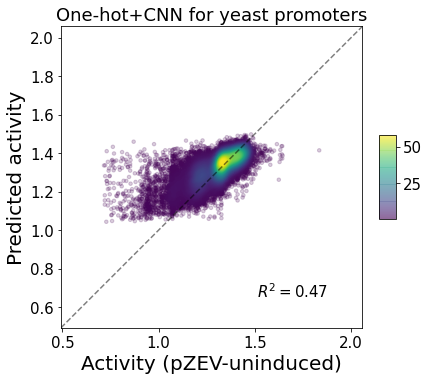

In [5]:
loss_fn = nn.SmoothL1Loss() if promoter == 'yeast' else nn.CrossEntropyLoss()

print(f'Using {embedding} pipeline on {promoter} promoters.')
true, pred = test_loop(model, val_loader, loss_fn, embedding, promoter)

if promoter == 'human':
    print('auc:', roc_auc_score(true, pred))
    print(f'f1 score: {f1_score(true, pred):.3f}')
    print(f'mcc: {matthews_corrcoef(true, pred):.3f}')
    print(f'precision: {precision_score(true, pred):.3f}')
    print(f'recall: {recall_score(true, pred):.3f}')
if promoter == 'yeast':
    plot_predictions(true, pred, 'yeast')